In [ ]:
# flake8: noqa: T201
from cyber.models.world.dynamic.genie.st_mask_git import STMaskGIT
from cyber.dataset import RawTokenDataset
from einops import rearrange
import torch

In [ ]:
# function for visualization, adapted from OpenMAGVIT
def rescale_magvit_output(magvit_output):
    """
    [-1, 1] -> [0, 255]

    Important: clip to [0, 255]
    """
    rescaled_output = (magvit_output.detach().cpu() + 1) * 127.5
    clipped_output = torch.clamp(rescaled_output, 0, 255).to(dtype=torch.uint8)
    return clipped_output

In [ ]:
# restore from pretrained model
genie = STMaskGIT.from_pretrained("path/to/Cyber/pretrained/STMaskGIT")
genie = genie.cuda()
genie.eval()

In [ ]:
# load MAGVIT
from omegaconf import OmegaConf
from cyber.models.world.autoencoder.magvit2.models.lfqgan import VQModel

magvit2_base_conf = OmegaConf.load("path/to/pretrained/VQGAN/config.yaml")
magvit2_base = VQModel(magvit2_base_conf, ckpt_path="path/to/pretrained/VQGAN/model.ckpt")

In [8]:
# load data
pipette_data = RawTokenDataset("path/to/cyber_pipette/data", window_size=16)

In [9]:
one_ep = pipette_data[0]
one_ep_id: torch.Tensor = one_ep["input_ids"]
one_ep_label: torch.Tensor = one_ep["labels"]
print("are the inputs and labels equal?", torch.equal(one_ep_id, one_ep_label))

are the inputs and labels equal? True


In [ ]:
with torch.no_grad():
    result = genie.forward(one_ep_id[: 15 * 256].unsqueeze(0).to("cuda"), 1)

In [16]:
print("predicted:", result[0][15 * 256 :].cpu())
print("truth:", one_ep_label[15 * 256 :])

predicted: tensor([133582,  81615, 119185, 119185, 119263, 119263, 120286, 181886, 120281,
        120254, 119199, 151519, 151519, 131461,  43397, 142725, 174432, 244064,
        240751, 250225, 119263, 120287, 120287, 128254, 128360, 119189,  28639,
        119928, 119140,  80261,  10629, 142725, 141664, 174449, 261488, 261265,
        185809, 120217, 119263, 128254,  87262, 119263, 182128,  86489, 119189,
         86238, 142725,  43397,  12128, 159584, 159600, 192145, 193681, 161505,
        120273, 120213, 128479, 119825,  87257, 120281, 119293, 258437, 216920,
         27097,  28528,  64918, 142704, 159384, 241485, 212633, 127455, 120273,
         87513,  87104, 120030,  87131,  87117, 259549, 119249, 202143, 159464,
        192152,  59760, 142704, 212559, 193937, 128158,  87445, 120221, 120025,
        128160,  28625,  87247, 202193, 250261, 208069, 190072, 189500, 159088,
         62552, 193868, 208278, 212374, 128153,  87160,  87257, 120217, 159621,
        159623, 141097, 20213

In [ ]:
# MAGVIT uses mixed precision
dtype = torch.bfloat16

In [ ]:
# model and data prep
magvit2_base.to("cuda", dtype=dtype)
batch = rearrange(result[0], "(b h w) -> b h w", b=16, h=16).to("cuda")

In [ ]:
# decode prediction
with torch.no_grad():
    # visualize results
    quant = magvit2_base.quantize.get_codebook_entry(rearrange(batch, "b h w -> b (h w)"), bhwc=(*batch.shape, magvit2_base.quantize.codebook_dim)).flip(1)
    decoded = rescale_magvit_output(magvit2_base.decode(quant.to("cuda", dtype=dtype)))

In [ ]:
import torchvision.transforms.v2.functional as transforms_f

decoded_rgb = [transforms_f.to_pil_image(decoded[i].cpu()) for i in range(len(decoded))]

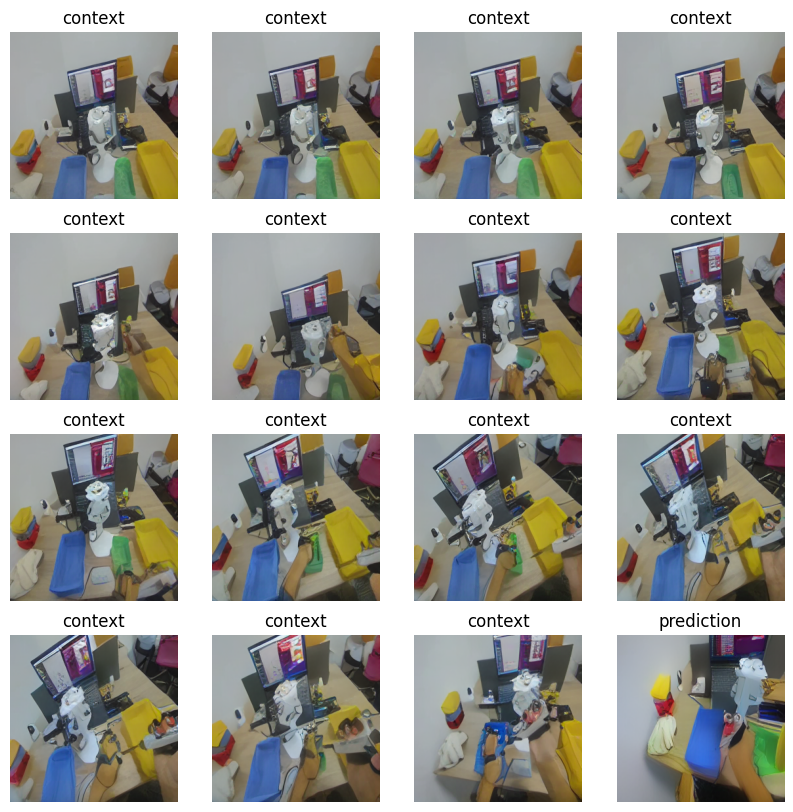

In [ ]:
import matplotlib.pyplot as plt

# create a grid of images
# for the first 15 images, mark them as context
# for the last image, mark it as prediction
fig, axs = plt.subplots(4, 4, figsize=(10, 10))
for i in range(16):
    ax = axs[i // 4, i % 4]
    ax.imshow(decoded_rgb[i])
    ax.axis("off")
    ax.set_title("context" if i < 15 else "prediction")